<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Pre_trained_Image_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git -q
!pip install pytorch-lightning -q
!git clone https://github.com/hila-chefer/Transformer-Explainability.git
!pip install einops -q

     |████████████████████████████████| 849kB 11.0MB/s 
     |████████████████████████████████| 829kB 24.5MB/s 
     |████████████████████████████████| 184kB 33.7MB/s 
     |████████████████████████████████| 112kB 40.1MB/s 
     |████████████████████████████████| 276kB 39.7MB/s 
     |████████████████████████████████| 1.3MB 35.4MB/s 
     |████████████████████████████████| 143kB 40.4MB/s 
     |████████████████████████████████| 296kB 37.0MB/s 
Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (332/332), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 332 (delta 163), reused 181 (delta 69), pack-reused 0
Receiving objects: 100% (332/332), 2.87 MiB | 9.75 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [2]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
!7z x /content/Train.7z

--2021-04-28 11:51:40--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13524763 (13M) [application/octet-stream]
Saving to: ‘Train.7z’

Train.7z            100%[===================>]  12.90M  54.6MB/s    in 0.2s    

2021-04-28 11:51:42 (54.6 MB/s) - ‘Train.7z’ saved [13524763/13524763]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 13524763 bytes (13 MiB)

Extracting archive: /content/Train.7z
--
Path = /content/Train.7z
Ty

In [3]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
!7z x /content/Val.7z

--2021-04-28 11:51:44--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4593856 (4.4M) [application/octet-stream]
Saving to: ‘Val.7z’

Val.7z              100%[===================>]   4.38M  --.-KB/s    in 0.09s   

2021-04-28 11:51:44 (50.5 MB/s) - ‘Val.7z’ saved [4593856/4593856]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 4593856 bytes (4487 KiB)

Extracting archive: /content/Val.7z
--
Path = /content/Val.7z
Type = 7z
Phy

In [1]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pytorch_lightning.callbacks import ModelCheckpoint

from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

## Cleaning and getting a final data

In [ ]:
## Getting images(file path) from the directories 

imgs = []
for path, subdirs, files in os.walk('./Dataset'):
    for name in files:
        imgs.append(os.path.join(path, name))
imgs = [x for x in imgs if '.csv' not in x]

In [ ]:
data = pd.read_excel("/content/Dataset/all_meta_data.xlsx")
data.head()

,phylum,class,genus,species,form,sample,image_name,image_url,img_path
0,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_worm4_HB.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_worm4_HB.jpg
1,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_HBa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_HBa.jpg
2,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_wtmt.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_wtmt.jpg
3,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_SC_egg.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_SC_egg.jpg
4,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_UVa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_UVa.jpg


In [ ]:
data = pd.read_csv('/content/parasites.csv')

In [ ]:
data['species'].value_counts()

Plasmodium malariae          185
Cyclospora cayetanensis      185
Entamoeba histolytica        180
Ascaris lumbricoides         180
Plasmodium vivax             180
Plasmodium falciparum        180
Giardia duodenalis           180
Plasmodium ovale             170
Strongyloides stercoralis    110
Dibothriocephalus latus      105
Trichuris Trichuria           95
Enterobius vermicularis       90
Toxocara canis                85
Ancyclostoma sp               85
Sarcocystis sp                80
Cryptosporidium sp            80
Plasmodium knowlesi           75
Hymenolepis nana              70
Toxoplasma gondii             65
Trichinella sp                65
Name: species, dtype: int64

In [ ]:
# data = [x for _,x in data.groupby('species') if len(x)>15]

# data = pd.concat(data,ignore_index=True)

label_encoders = dict()
labels = ["phylum","class","species","form","sample"]
for x in labels:
  le = LabelEncoder()
  data[f'{x}_label'] = le.fit_transform(data[x])
  label_encoders[x] = le

In [ ]:
train, val = train_test_split(
    data, test_size=0.25, random_state=2021,stratify = data['species'])

In [ ]:
train.to_csv('/content/train.csv',index = False)

val.to_csv('/content/val.csv',index = False)

# Labeling

In [2]:
train = pd.read_csv("/content/train/train.csv")

val = pd.read_csv("/content/val/val.csv")

In [3]:
le = LabelEncoder()
train['species_label'] = le.fit_transform(train['species'])

val['species_label'] = le.transform(val['species'])

# Dataset Function

In [4]:
from PIL import Image
from glob import glob
images = [x for x in glob('./val/*/*') if 'val.csv' not in x]
for i in images:
  Image.open(i).convert('RGB').save(i)

In [5]:
class SpeciesDataset(Dataset):
  def __init__(self,csv_file,transform):
    super().__init__()
    csv = csv_file[['species_label','img_path']]
    self.labels = csv['species_label'].values

    self.images = csv['img_path'].values
    self.transform = transform

    # self.LE = LabelEncoder()
    # self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return {'images':img, 'labels':label}

In [6]:

train_transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [ ]:
16*135,16*45

(2160, 720)

In [ ]:
val['species'].value_counts()

Plasmodium vivax             45
Plasmodium falciparum        45
Cyclospora cayetanensis      40
Plasmodium malariae          40
Entamoeba histolytica        35
Ascaris lumbricoides         35
Plasmodium ovale             35
Giardia duodenalis           35
Trichuris Trichuria          25
Dibothriocephalus latus      25
Hymenolepis spp              25
Strongyloides stercoralis    20
Cryptosporidium sp.          20
Sarcocystis sp.              20
Ancyclostoma sp.             20
Enterobius vermicularis      20
Name: species, dtype: int64

In [7]:
class_counts = train['species_label'].value_counts().to_dict()
train_weights = torch.tensor([1/class_counts[label] for label in train['species_label'].values])

train_dataset = SpeciesDataset(train,transform=train_transformer)

class_counts = val['species_label'].value_counts().to_dict()
val_weights = torch.tensor([1/class_counts[label] for label in val['species_label'].values])

val_dataset = SpeciesDataset(val,transform=val_transformer)

# VIT Base Imagenet 21k

In [8]:
class ViT(pl.LightningModule):
  def __init__(
      self,
      num_classes_classifier,
      train_weights,
      val_weights,
      train_dataset,
      val_dataset):
    super().__init__()

    self.tw = train_weights
    self.vw = val_weights

    self.train_dataset = train_dataset
    self.val_dataset = val_dataset


    self.loss_fn = nn.CrossEntropyLoss()

    self.img_transformer = timm.models.vision_transformer.vit_base_patch16_224_in21k(pretrained=True,num_classes = num_classes_classifier)
    # self.q = nn.Linear(768,512)
    # self.k = nn.Linear(768,512)
    # self.v = nn.Linear(768,512)
    # # self.drop = nn.Dropout(0.4)
    # self.mha = nn.MultiheadAttention(512,8)

    # self.act_layer = nn.GELU()

    # self.classifier = nn.Sequential(nn.BatchNorm1d(512),
    #                                 nn.Linear(512,num_classes_classifier))

  def forward(self,img):
    # repr = torch.relu(self.img_transformer(img)).unsqueeze(dim=0)
    # q,k,v = self.q(repr),self.k(repr),self.v(repr)
    # repr,_ = self.mha(q,k,v) 
    # # repr = self.drop(repr)
    # repr = self.act_layer(repr).squeeze(dim=0)
    # output = self.classifier(repr)
    # return output  
    return self.img_transformer(img)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(
        self.train_dataset,
        batch_size=32,
        sampler=torch.utils.data.WeightedRandomSampler(self.tw,num_samples=2160),
        num_workers = os.cpu_count()
        )

  def val_dataloader(self):
    return torch.utils.data.DataLoader(
        self.val_dataset,
        batch_size = 51,
        sampler=torch.utils.data.WeightedRandomSampler(self.vw,num_samples=720),
        num_workers = os.cpu_count()
        )
    
  def training_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.loss_fn(outputs,labels)
    acc = (outputs.argmax(dim=1).view(labels.size()).data == labels.data).sum()/labels.size(0)
    
    # self.log("loss",loss,prog_bar=True)
    self.log("accuracy",acc,prog_bar=True)
    return {"loss": loss,'accuracy':acc}

  def validation_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.loss_fn(outputs,labels)
    acc = (outputs.argmax(dim=1).view(labels.size()).data == labels.data).sum()/labels.size(0)
    
    # self.log("val_loss",loss,prog_bar=True)
    # self.log("val_accuracy",acc,prog_bar=True)
    return {"val_loss": loss.item(),'val_accuracy':acc.item()}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.tensor(
            [output["val_loss"] 
            for output in outputs]
            ).mean()
    avg_acc = torch.tensor(
            [output["val_accuracy"] 
            for output in outputs]
            ).mean()
    
    self.log("val_loss",avg_loss,prog_bar=True)
    self.log("val_accuracy",avg_acc,prog_bar=True)

  def configure_optimizers(self):
    optimizer = [torch.optim.AdamW(
            self.parameters(), 
            lr=1e-4
        )]
    # schedulers = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #         optimizer[0],
    #         mode='max'
    #     )
    return optimizer


In [9]:
model = ViT(
    num_classes_classifier=16,
    train_weights=train_weights,
    val_weights=val_weights,
    train_dataset=train_dataset,
    val_dataset=val_dataset
    )

Removing representation layer for fine-tuning.


In [11]:
# early_stop_callback = EarlyStopping(
#    monitor='val_accuracy',
#    min_delta=0.00,
#    patience=20,
#    verbose=False,
#    mode='max'
# )

# model_ckpt = ModelCheckpoint(
#     monitor='val_accuracy',
#     dirpath='./',
#     filename='ViT-{val_accuracy:.2f}',
#     mode='max')

trainer = pl.Trainer(gpus=1,max_epochs=120,accumulate_grad_batches=4,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | loss_fn         | CrossEntropyLoss  | 0     
1 | img_transformer | VisionTransformer | 85.8 M
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.244   Total estimated model params size (MB)


1

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset(val,transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51)

model = ViT.load_from_checkpoint("/content/ViT-val_accuracy=0.76.ckpt",num_classes_classifier=16,
    train_weights=None,
    val_weights=None,
    train_dataset=None,
    val_dataset=None
    )
model.cuda()
model.eval()
preds = np.array([])
label = np.array([])
with torch.no_grad():
  for batch in val_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    label = np.append(label,labels)
    prediction = model(images)
    preds = np.append(preds,prediction.argmax(dim=1).view(labels.size()).cpu().numpy())


print(classification_report(label,preds,target_names=le.classes_))

Removing representation layer for fine-tuning.


                           precision    recall  f1-score   support

         Ancyclostoma sp.       0.68      0.95      0.79        20
     Ascaris lumbricoides       1.00      0.89      0.94        35
      Cryptosporidium sp.       0.91      0.50      0.65        20
  Cyclospora cayetanensis       0.80      1.00      0.89        40
  Dibothriocephalus latus       0.80      0.80      0.80        25
    Entamoeba histolytica       0.83      0.97      0.89        35
  Enterobius vermicularis       0.55      0.30      0.39        20
       Giardia duodenalis       0.87      0.94      0.90        35
          Hymenolepis spp       0.83      0.40      0.54        25
    Plasmodium falciparum       0.73      0.78      0.75        45
      Plasmodium malariae       0.89      0.40      0.55        40
         Plasmodium ovale       0.54      0.60      0.57        35
         Plasmodium vivax       0.58      0.78      0.67        45
          Sarcocystis sp.       0.94      0.80      0.86     

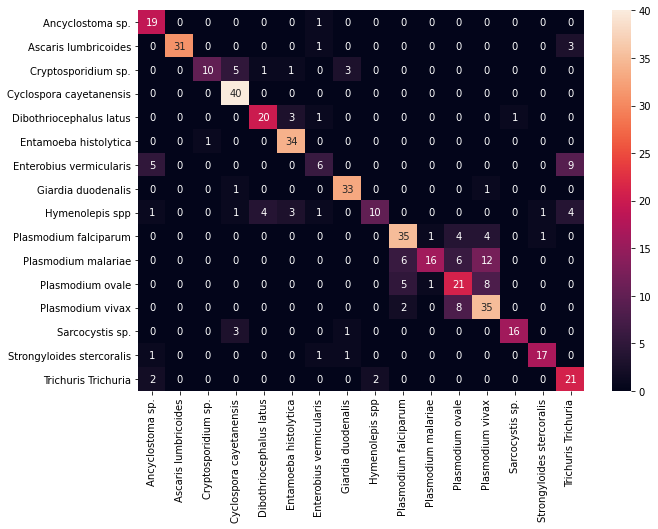

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(label,preds)
df_cm = pd.DataFrame(confusion, index = le.classes_,
                  columns = le.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# LRP

In [19]:
%cd ..

/content


In [18]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained
Model = vit_LRP(pretrained=True,num_classes = 16)
Model.load_state_dict(model.img_transformer.state_dict())
Model.cuda()
Model.eval()
attribution_generator = LRP(Model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

In [24]:
le.classes_,le.transform(['Giardia duodenalis'])

(array(['Ancyclostoma sp.', 'Ascaris lumbricoides', 'Cryptosporidium sp.',
        'Cyclospora cayetanensis', 'Dibothriocephalus latus',
        'Entamoeba histolytica', 'Enterobius vermicularis',
        'Giardia duodenalis', 'Hymenolepis spp', 'Plasmodium falciparum',
        'Plasmodium malariae', 'Plasmodium ovale', 'Plasmodium vivax',
        'Sarcocystis sp.', 'Strongyloides stercoralis',
        'Trichuris Trichuria'], dtype=object), array([7]))

In [22]:
def plot_get(img_path,class_name,clsidx):
  img = Image.open(img_path)
  image = transform(img)
  fig, axs = plt.subplots(1, 2)
  axs[0].imshow(img);
  axs[0].axis('off');

  img = generate_visualization(image, class_index=clsidx)

  axs[1].imshow(img);
  axs[1].axis('off');

  Image.fromarray(img).save(f"{class_name}={img_path.split('/')[3]}",dpi=(600,600))

In [52]:
val[val['species_label']==0].sample().values

array([['Nematoda', 'Chromadorea', 'Ancylostoma', 'Ancyclostoma sp.',
        'egg', 'feces', './val/Ancyclostoma sp./Hookworm_2x2_B_0_3.jpg',
        0]], dtype=object)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


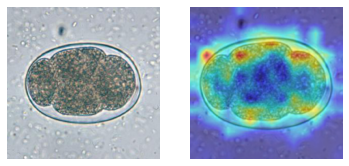

In [53]:
plot_get(
    './val/Ancyclostoma sp./Hookworm_2x2_B_0_3.jpg',
    'Ancyclostoma sp.',
    0
)